<a href="https://colab.research.google.com/github/Amika2000/Portfolio-Projects/blob/main/Carbon%20Prediction%20using%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><center> Notebook used for the Ernst & Young Carbon Prediction Hackathon</h2></center>
<figure>


*About the problem*
> The ability to accurately monitor carbon emissions is a critical step in the fight against climate change. Precise carbon readings allow researchers and governments to understand the sources and patterns of carbon mass output. While Europe and North America have extensive systems in place to monitor carbon emissions on the ground, there are few available in Africa.

*Objective of this challenge*
> The objective of this challenge is to create machine learning or a deep learning model using open-source CO2 emissions data (from Sentinel-5P satellite observations) to predict carbon emissions.
(I chose to create a machine learning model.)





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Table of contents:

1. [Installing and importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Outliers](#Outliers)
5. [Geo Visualisation - EDA](#Geo)
5. [Missing values and duplicates](#Missing)
6. [Date features EDA](#Dates)
7. [Correlations - EDA](#Correlations)
9. [Timeseries visualization - EDA](#Timeseries)
10. [Feature engineering](#Engineering)
11. [Modelling](#Modelling)
12. [Making predictions of the test set and creating a submission file](#Predictions)

<a name="Libraries"></a>
## 1. Installing and importing libraries


In [ ]:
%%capture
# Install relevant libraries
!pip install geopandas folium

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from math import log
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5f}'.format
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

<a name="Data"></a>
## 2. Loading and previewing data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Data'
# Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'Train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'Test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'SampleSubmission.csv'))

# Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,86.05170
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,88.87567
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,91.72311
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,92.88387
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,94.87833


In [ ]:
# Preview test dataset
test.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,74897.05200,2180.26654,81287.07448,1562.03102,10.73412,0.28066,-31.23017,33.33797,-93.21726,23.35825
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,84222.65352,982.61906,90307.65001,927.11122,5.25002,0.23893,66.49090,58.13779,-85.00147,13.41648
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,78922.49079,1582.96493,85383.15185,1006.77811,6.81937,0.25868,75.92319,41.33695,-83.26754,16.27300
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,61135.91959,3935.41998,67490.03136,3428.42353,6.23363,0.28154,-11.02323,60.68987,-77.76372,22.79396
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,78494.24739,1647.53853,84478.74304,1122.53409,11.81025,0.28156,-13.29451,51.00713,-76.62065,23.19824


In [ ]:
# Preview sample submission file
samplesubmission.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,0
1,ID_-23.53_27.47_2019_2,0
2,ID_-23.53_27.47_2019_3,0
3,ID_-23.53_27.47_2019_4,0
4,ID_-23.53_27.47_2019_5,0


In [ ]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((74005, 76), (28085, 75), (28085, 2))

In [ ]:
# Train to test sets ratio
(test.shape[0]) / (train.shape[0] + test.shape[0])

0.2751004016064257

<a name="Statistics"></a>
## 3. Statistical summaries

In [ ]:
# Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,74005.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-23.73_28.77_2019_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7891.06097
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,52571.60466
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,0.04806
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,154.54720
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,723.13586
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,2773.02930


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from year *2019 to 2022*
 - Minimum recorded CO2 emissions is *0.04806* and a maximum of *1181701.2*
 - Week of the year starts from 1 to 52
 - The latitude and longitudes ranges show that the regions are mostly within South Africa

The target variable is skewed to the right with a a degree of ~17. We want our target variable to be normally distributed, since this is a rule we have to abide by for regression.

Some of the techniques used to handle skewness include:
- Log transform
- Box-cox transform
- Square root transform
- *etc*

**Mathematics behind Box-Cox Transformation:**
How can we convert our intuitive thinking into a mathematical transformation function? Logarithmic transformation is all we need. When a log transformation is applied to non-normal distribution, it tries to expand the differences between the smaller values because the slope for the logarithmic function is steeper for smaller values whereas the differences between the larger values can be reduced because, for large values, log distribution has a moderate slope. That is what we thought of doing, right? Box-cox Transformation only cares about computing the value of $\lambda$ which varies from -5 to 5. A value of $\lambda$ is said to be best if it is able to approximate the non-normal curve to a normal curve. The transformation equation is as follows:

$$y(\lambda)=\begin{cases}
  \left(y^{\lambda}-1\right) / \lambda, \text { if } \lambda \neq 0, \\
  \log y \quad, \text { if } \lambda=0.
\end{cases}$$

This function requires input to be positive. Using this formula manually is a very laborious task thus many popular libraries provide this function.

**Implementation:**
SciPy’s stats package provides a function called boxcox for performing box-cox power transformation that takes in original non-normal data as input and returns fitted data along with the lambda value that was used to fit the non-normal distribution to normal distribution. Following is the code for the same.

Lambda value used for Transformation: 0.057450389972568995


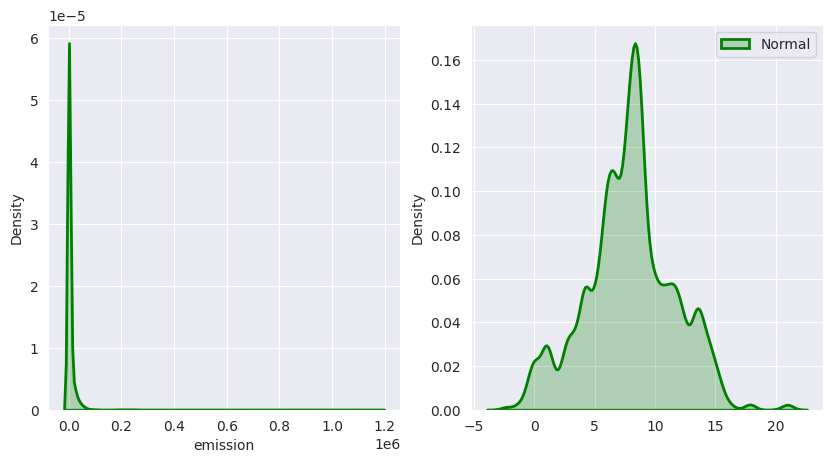

In [ ]:
# box-cox transform

# transform training data & save lambda value
fitted_emission, fitted_lambda = stats.boxcox(train.emission)

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(train.emission, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_emission, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2},
            label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")


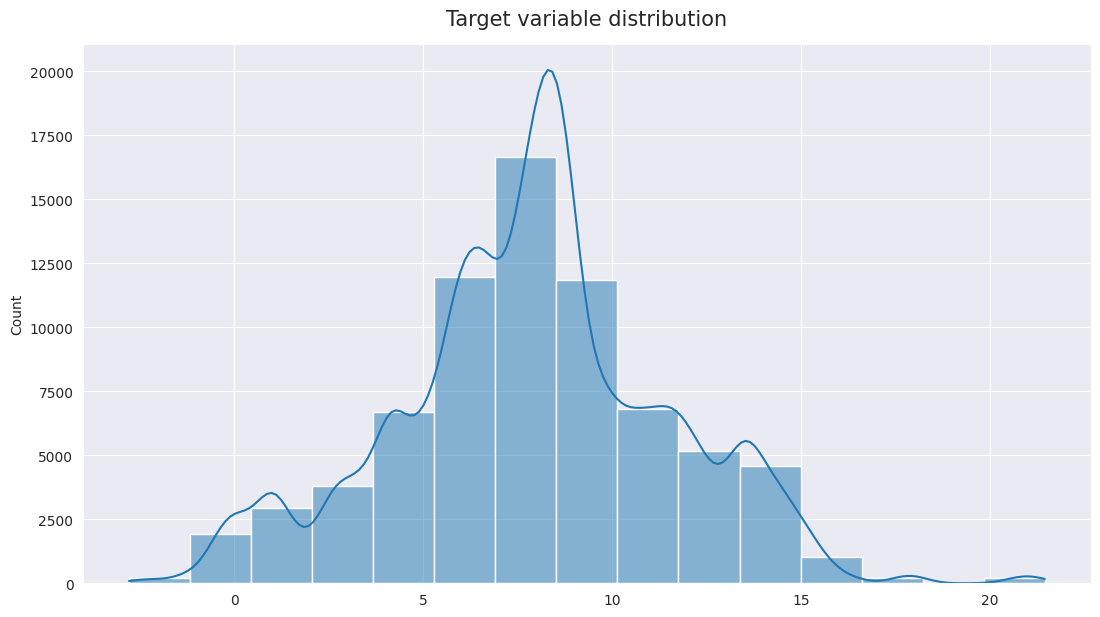

None

17.038027449698163

In [ ]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.histplot(fitted_emission, kde = True, bins = 15)
plt.title('Target variable distribution', y = 1.02, fontsize = 15)
display(plt.show(), train.emission.skew())

<a name="Outliers"></a>
## 4. Outliers


Outliers are those data points which differ significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median etc.

We will deal with outliers in the emission column only. We do this by replacing the values above the maximum value and those below the minimum term with NaN. In the 'Missing values and duplicates' section, we will deal with these NaN terms.


In [ ]:
g = fitted_emission

q75,q50,q25 = np.percentile(g,[75,50,25]) # derive the upper quartile, median and lower quartile here
intr_qr = q75-q25 # inter quartile range

max = q75+(1.5*intr_qr)
min = q25-(1.5*intr_qr)

x=0
while x <len(g):
    if g[x] < min or g[x] > max:
      g[x] = np.nan
    x = x + 1

train.emission = g

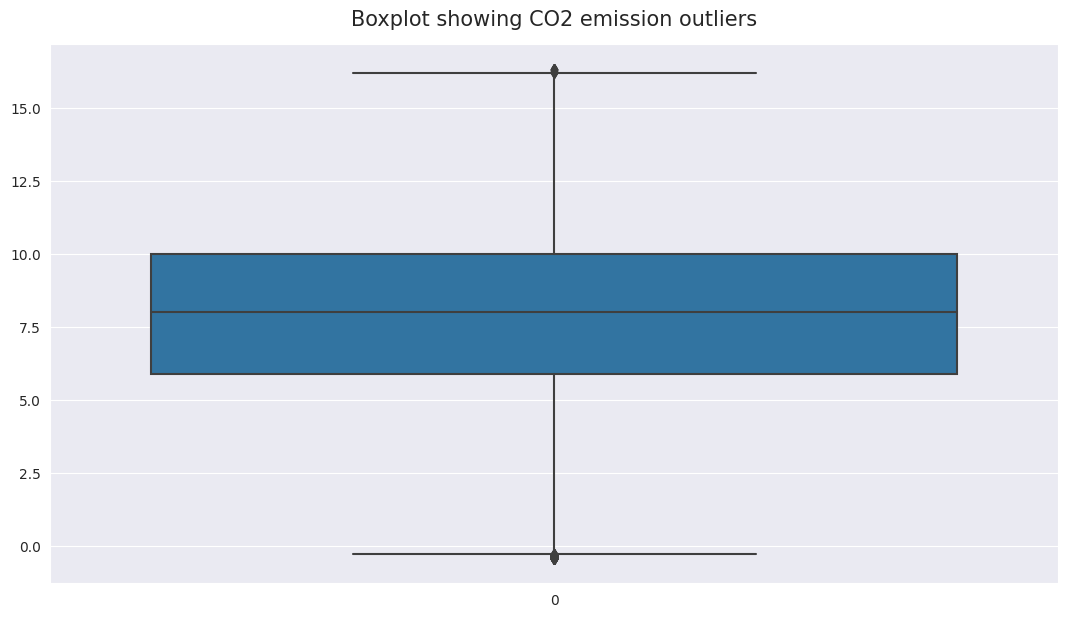

In [ ]:
# Plotting boxplot for the CO2 emissions
sns.set_style('darkgrid')
plt.figure(figsize = (13, 7))
sns.boxplot(train.emission)
plt.title('Boxplot showing CO2 emission outliers', y = 1.02, fontsize = 15)
plt.show()

In [ ]:
train.describe(include="all")

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,74005,74005.00000,74005.00000,74005.00000,74005.00000,72075.00000,72075.00000,72075.00000,72075.00000,72075.00000,...,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,71281.00000,72901.00000
unique,74005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-23.73_28.77_2019_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-27.82972,27.78274,2020.47805,26.15610,0.00026,0.51587,0.00009,0.10569,4.48763,...,3652.34972,74390.62446,2871.26282,15.82539,0.22544,-14.27712,49.56784,-50.51322,40.55896,7.90875
std,NaN,2.76059,2.74667,1.11126,14.84384,0.00060,0.19677,0.00020,0.06955,52.24654,...,1807.38528,12859.06733,1645.82767,19.69665,0.06313,47.27732,12.09742,20.62391,12.20118,3.45238
min,NaN,-33.93000,21.07000,2019.00000,1.00000,-0.00099,0.13374,-0.00083,0.00000,-110.02766,...,128.29979,14541.97799,10.30036,1.15114,0.00000,-125.29806,0.10088,-97.57091,10.90623,-0.44635
25%,NaN,-29.63000,26.67000,2019.00000,13.00000,-0.00007,0.37174,-0.00003,0.05248,-18.17813,...,2260.91745,65920.34050,1602.61523,5.07185,0.18349,-31.95209,41.32913,-67.98772,29.78659,5.88337
50%,NaN,-28.13000,28.77000,2020.00000,26.00000,0.00015,0.48869,0.00007,0.09951,-10.98754,...,3437.87891,75994.80202,2563.92629,8.60904,0.22350,-13.73803,53.23303,-45.41392,40.11757,8.00881
75%,NaN,-25.73000,29.47000,2021.00000,39.00000,0.00044,0.62353,0.00019,0.15248,59.11999,...,4745.60794,84409.69113,3819.67139,17.47863,0.26772,3.79039,59.47813,-33.12496,51.44570,10.00321


<a name="Geo"></a>
## 5. Geo Visualisation - EDA

In [ ]:
# Combine train and test for easy visualisation
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
test_coords = test.drop_duplicates(subset = ['latitude', 'longitude'])
train_coords['set_type'], test_coords['set_type'] = 'train', 'test'

all_data = pd.concat([train_coords, test_coords], ignore_index = True)
# Create point geometries

geometry = gpd.points_from_xy(all_data.longitude, all_data.latitude)
geo_df = gpd.GeoDataFrame(
    all_data[["latitude", "longitude", "set_type"]], geometry=geometry
)

# Preview the geopandas df
geo_df.head()

,latitude,longitude,set_type,geometry
0,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
1,-23.73000,28.77000,train,POINT (28.77000 -23.73000)
2,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
3,-23.73000,28.87000,train,POINT (28.87000 -23.73000)
4,-23.73000,28.97000,train,POINT (28.97000 -23.73000)


In [ ]:
# Create a canvas to plot your map on
all_data_map = folium.Map(prefer_canvas=True)

# Create a geometry list from the GeoDataFrame
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

# Iterate through list and add a marker for each volcano, color-coded by its type.
i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type set
    if geo_df.set_type[i] == "train":
        type_color = "green"
    elif geo_df.set_type[i] == "test":
        type_color = "orange"

    # Place the markers
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius = 1,
            weight = 4,
            zoom =10,
            popup=
            "Set: " + str(geo_df.set_type[i]) + "<br>"
            "Coordinates: " + str([round(x, 2) for x in geo_df_list[i]]),
            color =  type_color),
        )
    i = i + 1
all_data_map.fit_bounds(all_data_map.get_bounds())
all_data_map

<a name="Missing"></a>
## 6. Missing values and duplicates

In [ ]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(True, True)

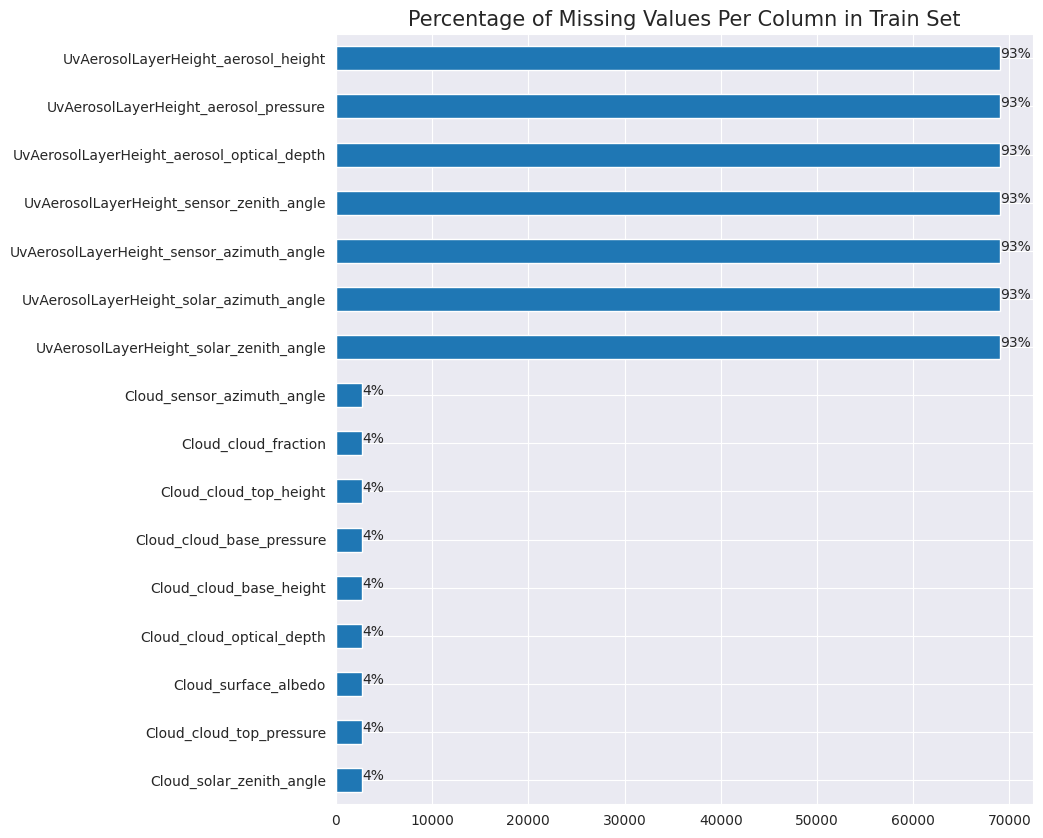

In [ ]:
# Plot missing values in train set
ax = train.isna().sum().sort_values(ascending = False)[:16][::-1].plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

**Impute Missing Values Using Sci-kit Learn Library (Multi-Variate Approach)**: We can impute missing values using the sci-kit library by creating a model to predict the observed value of a variable based on another variable which is known as regression imputation. In a multivariate approach, more than one feature is taken into consideration. There are two ways to impute missing values considering the multivariate approach: using KNNImputer or IterativeImputer classes. Let's see using the latter.

In [ ]:
train.isna().sum()

ID_LAT_LON_YEAR_WEEK                                            0
latitude                                                        0
longitude                                                       0
year                                                            0
week_no                                                         0
SulphurDioxide_SO2_column_number_density                     1930
SulphurDioxide_SO2_column_number_density_amf                 1930
SulphurDioxide_SO2_slant_column_number_density               1930
SulphurDioxide_cloud_fraction                                1930
SulphurDioxide_sensor_azimuth_angle                          1930
SulphurDioxide_sensor_zenith_angle                           1930
SulphurDioxide_solar_azimuth_angle                           1930
SulphurDioxide_solar_zenith_angle                            1930
SulphurDioxide_SO2_column_number_density_15km                1930
CarbonMonoxide_CO_column_number_density                       558
CarbonMono

In [ ]:
a = train.iloc[0:74006, 1:76] # removing first column and naming the new dataframe 'a'
a.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-23.73000,28.77000,2019,1,0.00017,0.71317,0.00010,0.22393,24.93944,56.89620,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,5.07696
1,-23.73000,28.77000,2019,2,-0.00016,0.81291,-0.00014,0.08028,16.62416,31.13726,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,5.11871
2,-23.73000,28.77000,2019,3,-0.00007,0.86031,-0.00006,0.16105,-13.23724,44.44106,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,5.15955
3,-23.73000,28.77000,2019,4,0.00015,0.42228,0.00009,0.04650,-13.53465,61.25250,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,5.17586
4,-23.73000,28.77000,2019,5,0.00002,1.00458,0.00003,0.21425,-13.47572,30.80077,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,5.20344


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
impute_it = IterativeImputer()
b = impute_it.fit_transform(a)     # b is new array created with the predicted values of NaN terms

In [ ]:
# Now we want to convert b, which is an array, to a panda dataframe:
df_b = pd.DataFrame(b, columns = list(a.columns))
df_b.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,-23.73000,28.77000,2019.00000,1.00000,0.00017,0.71317,0.00010,0.22393,24.93944,56.89620,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,5.07696
1,-23.73000,28.77000,2019.00000,2.00000,-0.00016,0.81291,-0.00014,0.08028,16.62416,31.13726,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,5.11871
2,-23.73000,28.77000,2019.00000,3.00000,-0.00007,0.86031,-0.00006,0.16105,-13.23724,44.44106,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,5.15955
3,-23.73000,28.77000,2019.00000,4.00000,0.00015,0.42228,0.00009,0.04650,-13.53465,61.25250,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,5.17586
4,-23.73000,28.77000,2019.00000,5.00000,0.00002,1.00458,0.00003,0.21425,-13.47572,30.80077,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,5.20344


In [ ]:
# We need to add back the untransformed columns back to the b dataframe(df_b)
# i.e the first column that we had omitted earlier to create the 'a' dataframe
extracted_col0 = train["ID_LAT_LON_YEAR_WEEK"]
df_b.insert(0, "ID_LAT_LON_YEAR_WEEK", extracted_col0)

In [ ]:
df_b.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-23.73_28.77_2019_1,-23.73000,28.77000,2019.00000,1.00000,0.00017,0.71317,0.00010,0.22393,24.93944,...,5566.22202,54826.03262,4606.20999,19.11528,0.35378,24.95195,49.05395,-89.63803,17.98887,5.07696
1,ID_-23.73_28.77_2019_2,-23.73000,28.77000,2019.00000,2.00000,-0.00016,0.81291,-0.00014,0.08028,16.62416,...,3711.51137,68491.75334,3034.46166,12.21866,0.24499,4.70886,42.58668,-89.90431,22.77325,5.11871
2,ID_-23.73_28.77_2019_3,-23.73000,28.77000,2019.00000,3.00000,-0.00007,0.86031,-0.00006,0.16105,-13.23724,...,2136.38519,78967.73955,1433.48259,6.06274,0.24510,76.06063,34.73754,-83.59525,17.43730,5.15955
3,ID_-23.73_28.77_2019_4,-23.73000,28.77000,2019.00000,4.00000,0.00015,0.42228,0.00009,0.04650,-13.53465,...,3841.85302,64592.80677,2878.51292,6.38823,0.21090,75.91237,60.29449,-71.89673,11.97782,5.17586
4,ID_-23.73_28.77_2019_5,-23.73000,28.77000,2019.00000,5.00000,0.00002,1.00458,0.00003,0.21425,-13.47572,...,1295.68817,86804.02539,1094.66534,9.20625,0.26110,-13.34608,50.19449,-77.46208,24.37427,5.20344


In [ ]:
train = df_b   # we now rename the dataframe 'df_b' as 'train'

<a name="Dates"></a>
## 7. Date features EDA

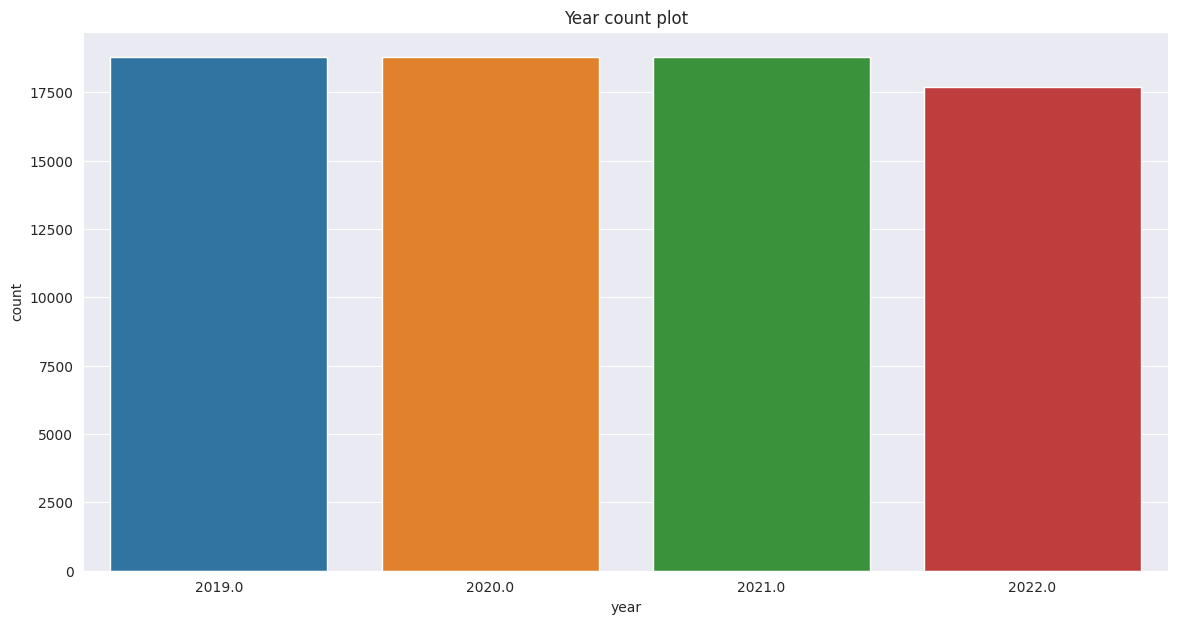

In [ ]:
# Year countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'year', data = train)
plt.title('Year count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the years
- Year 2022 has fewer number of observations

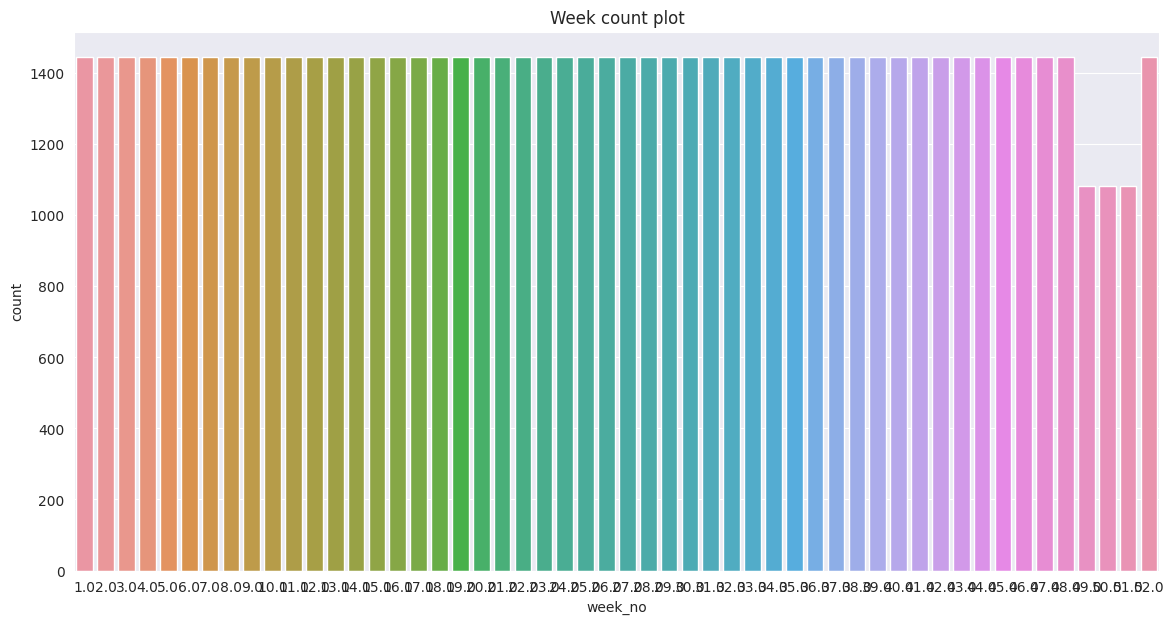

In [ ]:
# Week countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'week_no', data = train)
plt.title('Week count plot')
plt.show()

- The number of observations of CO2 emissions are relatively the same across the weeks
- Weeks 49, 50 and 51  have fewer number of observations when compared to the other weeks

In [ ]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019.00000,52
2020.00000,52
2021.00000,52
2022.00000,49


- The year 2022 has only 49 weeks available in the data

<a name="Correlations"></a>
## 8. Correlations - EDA

In [ ]:
# Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                 1.00000
longitude                                                0.43257
NitrogenDioxide_NO2_column_number_density                0.34371
NitrogenDioxide_tropospheric_NO2_column_number_density   0.34127
NitrogenDioxide_NO2_slant_column_number_density          0.31745
UvAerosolLayerHeight_sensor_zenith_angle                 0.14235
Ozone_cloud_fraction                                     0.11323
SulphurDioxide_SO2_column_number_density_amf             0.10527
CarbonMonoxide_sensor_altitude                           0.09816
NitrogenDioxide_cloud_fraction                           0.09640
Formaldehyde_HCHO_slant_column_number_density            0.08728
Formaldehyde_cloud_fraction                              0.08711
Formaldehyde_tropospheric_HCHO_column_number_density     0.08318
latitude                                                 0.07911
SulphurDioxide_cloud_fraction                            0.07811
SulphurDioxide_SO2_column

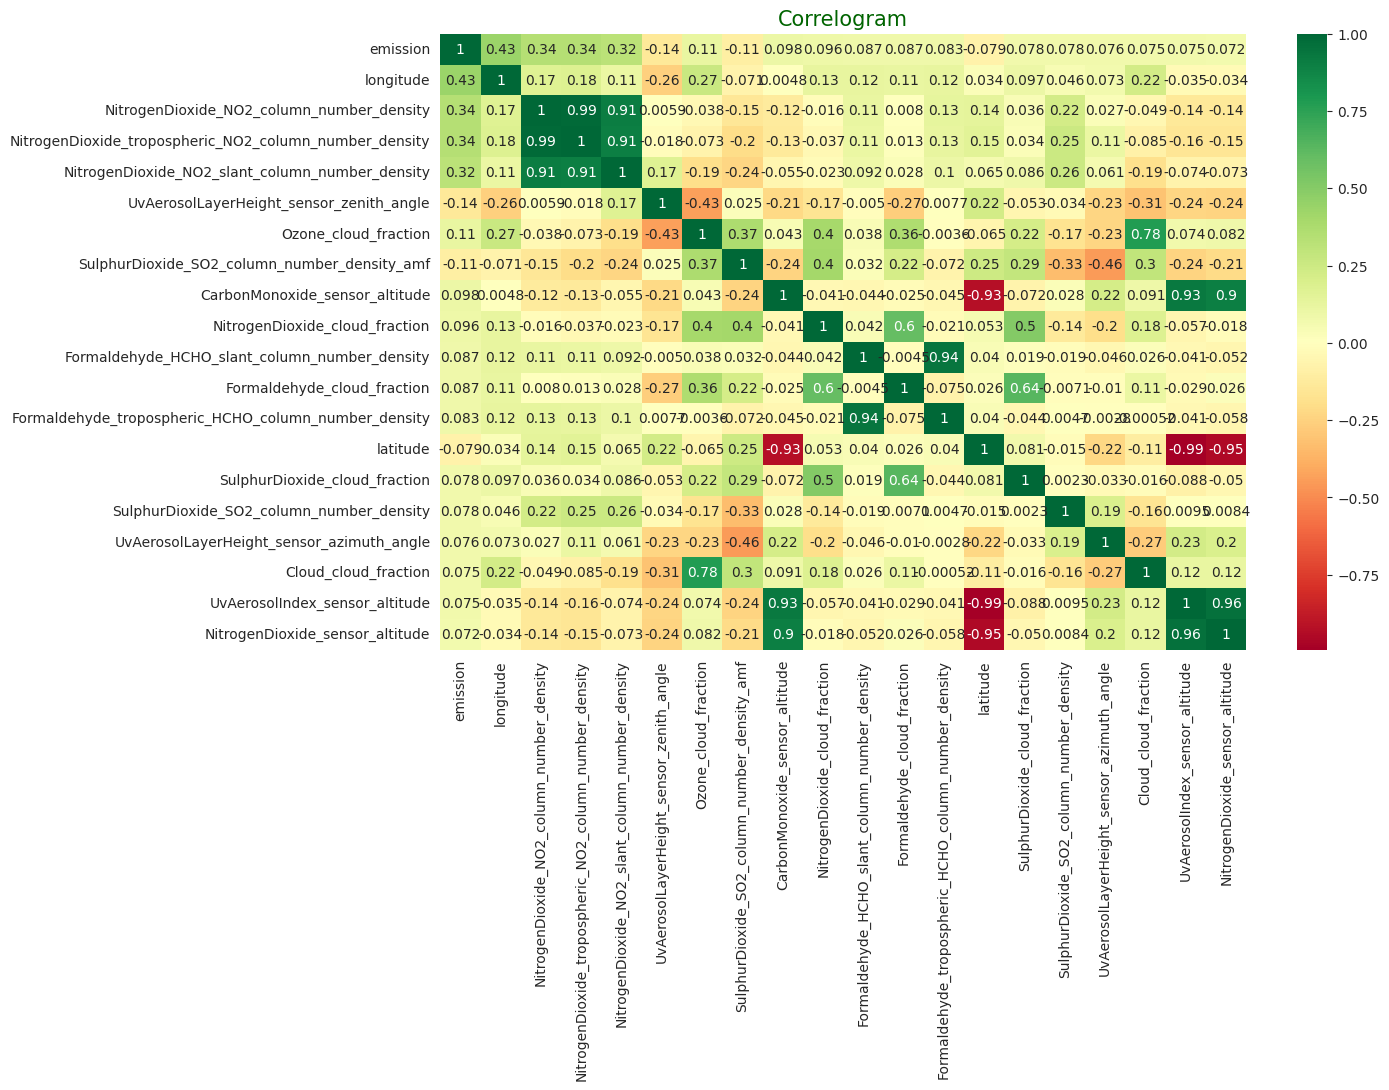

In [ ]:
# Quantify correlations between features
corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [ ]:
#List of significant correlations
# Set the threshold for correlation
threshold = 0.5

# Identify significant correlations above the threshold
significant_correlations = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        correlation = corr.iloc[i, j]
        if abs(correlation) > threshold:
            pollutant1 = corr.columns[i]
            pollutant2 = corr.columns[j]
            significant_correlations.append((pollutant1, pollutant2, correlation))

# Print the list of significant interactions
for interaction in significant_correlations:
    pollutant1, pollutant2, correlation = interaction
    print(f"Interaction between {pollutant1} and {pollutant2}: Correlation = {correlation}")


Interaction between NitrogenDioxide_NO2_column_number_density and NitrogenDioxide_tropospheric_NO2_column_number_density: Correlation = 0.9909413085477236
Interaction between NitrogenDioxide_NO2_column_number_density and NitrogenDioxide_NO2_slant_column_number_density: Correlation = 0.91394431341981
Interaction between NitrogenDioxide_tropospheric_NO2_column_number_density and NitrogenDioxide_NO2_slant_column_number_density: Correlation = 0.9060628276178325
Interaction between Ozone_cloud_fraction and Cloud_cloud_fraction: Correlation = 0.7818566205749599
Interaction between CarbonMonoxide_sensor_altitude and latitude: Correlation = -0.9276704382672313
Interaction between CarbonMonoxide_sensor_altitude and UvAerosolIndex_sensor_altitude: Correlation = 0.9268509706479106
Interaction between CarbonMonoxide_sensor_altitude and NitrogenDioxide_sensor_altitude: Correlation = 0.9005783600839683
Interaction between NitrogenDioxide_cloud_fraction and Formaldehyde_cloud_fraction: Correlation = 

In [ ]:
# Extract pollutants from the list of significant interactions
pollutants = []
for interaction in significant_correlations:
    pollutant1, pollutant2, _ = interaction
    if pollutant1 not in pollutants:
        pollutants.append(pollutant1)
    if pollutant2 not in pollutants:
        pollutants.append(pollutant2)

# Convert the pollutants list to an array
pollutants_array = np.array(pollutants)

# Print the array of pollutants
print(pollutants_array)

['NitrogenDioxide_NO2_column_number_density'
 'NitrogenDioxide_tropospheric_NO2_column_number_density'
 'NitrogenDioxide_NO2_slant_column_number_density' 'Ozone_cloud_fraction'
 'Cloud_cloud_fraction' 'CarbonMonoxide_sensor_altitude' 'latitude'
 'UvAerosolIndex_sensor_altitude' 'NitrogenDioxide_sensor_altitude'
 'NitrogenDioxide_cloud_fraction' 'Formaldehyde_cloud_fraction'
 'SulphurDioxide_cloud_fraction'
 'Formaldehyde_HCHO_slant_column_number_density'
 'Formaldehyde_tropospheric_HCHO_column_number_density']


In [ ]:
pollutant_to_remove = 'latitude' # remove latitude since it is not a pollutant
pollutants = np.delete(pollutants_array, np.where(pollutants == pollutant_to_remove))

<a name="Timeseries"></a>
## 9. Timeseries visualization - EDA

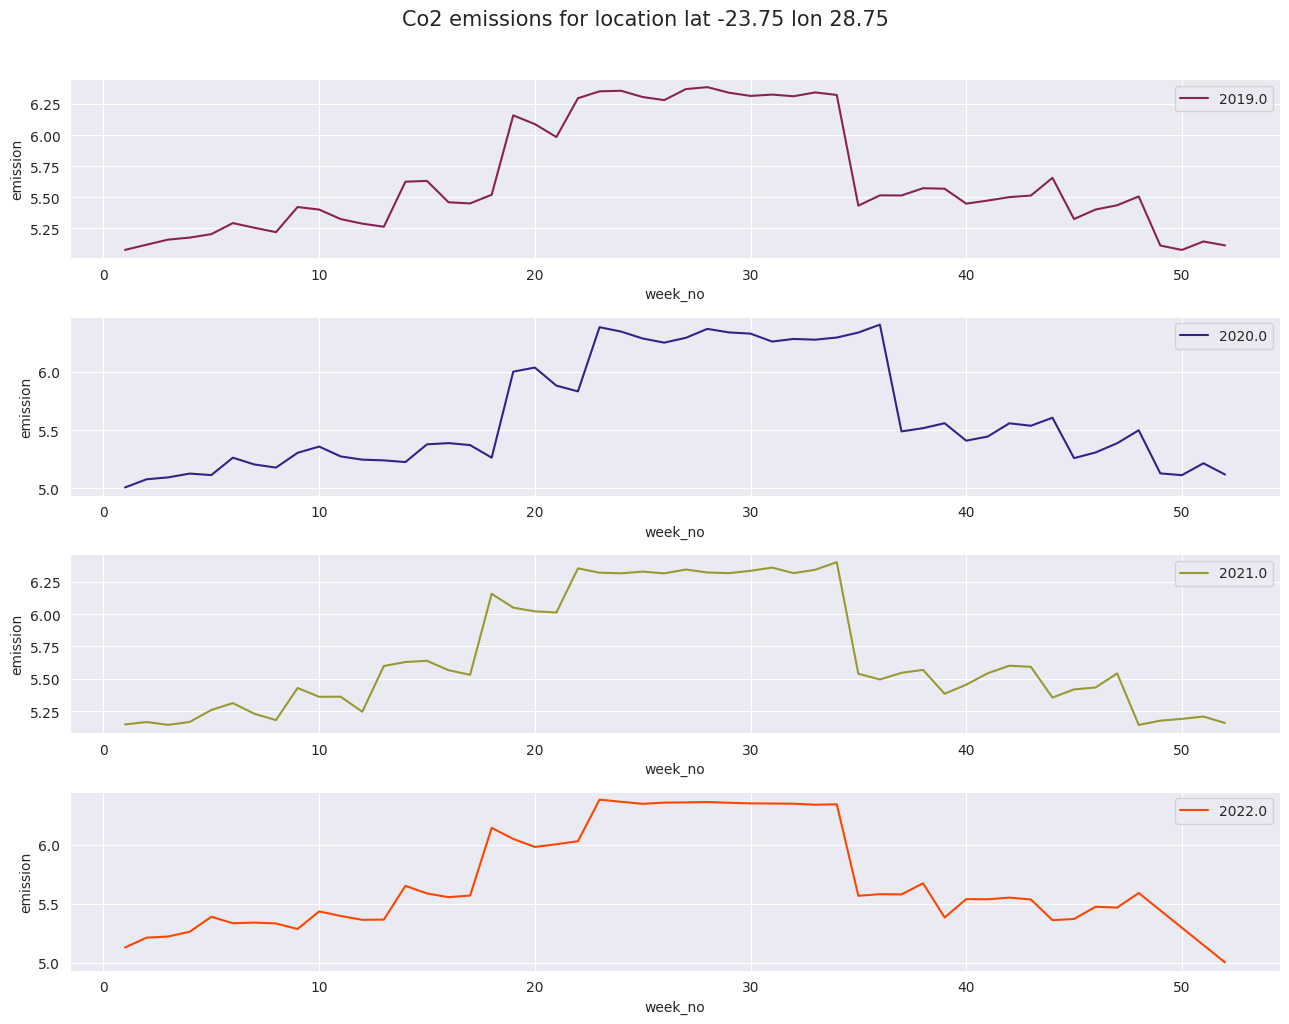

In [ ]:
# Sample a unique location and visualize its emissions across the years
train.latitude, train.longitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -23.73) & (train.longitude == 28.77)]

# Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = (13, 10))
fig.suptitle('Co2 emissions for location lat -23.75 lon 28.75', y=1.02, fontsize = 15)

for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288', '#999933' , 'orangered']):
  df = sample_loc[sample_loc.year == year]
  sns.lineplot(x=df.week_no,y= df.emission, ax = ax, label = year, color = color)
plt.legend()
plt.tight_layout()

<a name="Engineering"></a>
## 10. Feature engineering









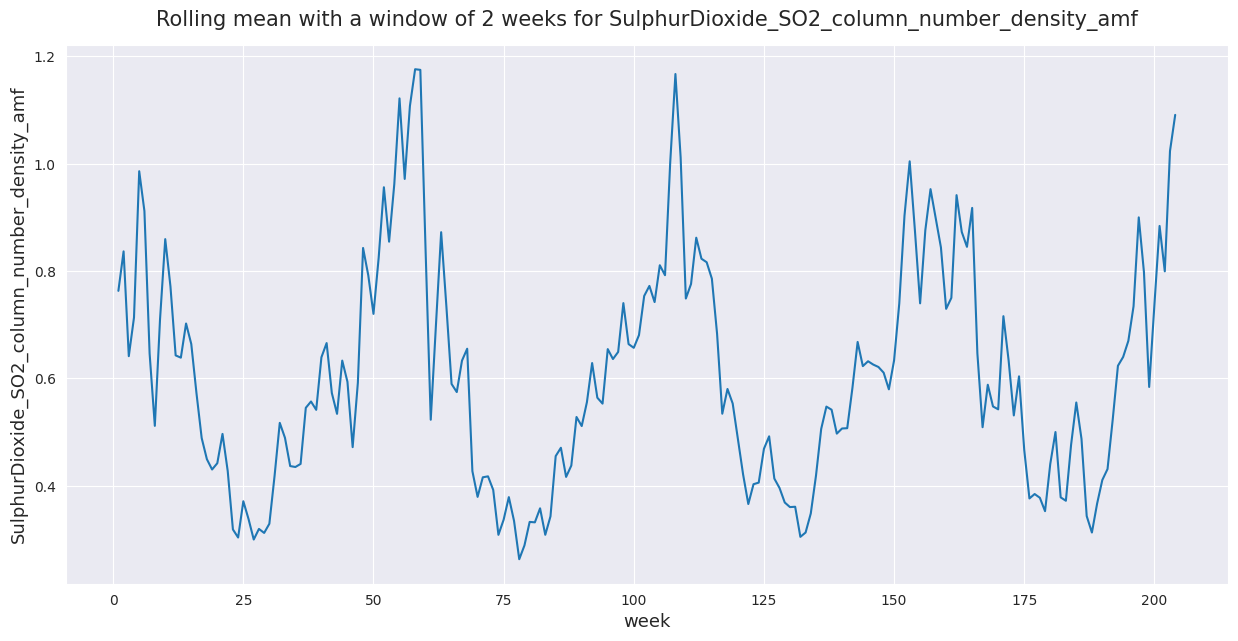

In [ ]:
# Examples of feature engineering - Aggregations, cumulative differences, moving averages ...
# Lets explore the rolling mean
# First we create a unique location from lat lon
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

# Filter based on one location
example_loc = train[train.location == '-23.73_28.77']

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualise rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y = 1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

 - There is a cyclic pattern from the above graph, which clearly shows that there is a pattern - This will be helpful to our model
 - With more research and domain knowledge generate useful features that can improve your model performance

 Other examples of feature engineering:
  - Creating cluster regions
  - Interactions between different pollutatnts - ratios, additions,subtractions...
  - Time series features

In [ ]:
# Generate the above feature - rolling mean for all locations for both the train and test

# Feature engineering train
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns]

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]


In [ ]:
# Merge engineered features with train and test set

#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)

# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-23.53_27.47_2019_1,-23.53000,27.47000,2019,1,0.00008,0.45447,0.00003,0.11429,-80.28631,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-23.53_27.47_2019_2,-23.53000,27.47000,2019,2,0.00018,0.42317,0.00006,0.07510,-17.76569,...,79559.85276,1581.44280,85797.36225,1244.57112,7.99207,0.25980,17.63036,45.73788,-89.10936,18.38737
2,ID_-23.53_27.47_2019_3,-23.53000,27.47000,2019,3,0.00006,0.71309,0.00004,0.11421,16.72565,...,81572.57215,1282.79200,87845.40093,966.94467,6.03470,0.24881,71.20704,49.73737,-84.13451,14.84474
3,ID_-23.53_27.47_2019_4,-23.53000,27.47000,2019,4,0.00048,0.43445,0.00017,0.13139,-22.47534,...,70029.20519,2759.19246,76436.59161,2217.60082,6.52650,0.27011,32.44998,51.01341,-80.51563,19.53348
4,ID_-23.53_27.47_2019_5,-23.53000,27.47000,2019,5,0.00019,0.78304,0.00014,0.16114,4.75036,...,69815.08349,2791.47925,75984.38720,2275.47881,9.02194,0.28155,-12.15887,55.84850,-77.19218,22.99610


## <a name="Modelling with Random Forest"></a>
## 11 a).  Modelling with Random Forest

In [ ]:
# Selecting the independent variables and the target variable
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

# Instantiating the model
clf = RandomForestRegressor(random_state = SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}') # 23432.342352754695

RMSE Score: 0.47570179726929024


In [ ]:
X_test.head()

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
36836,-28.13000,21.17000,2021.00000,38.00000,0.00036,0.40022,0.00011,0.12798,-11.32570,59.82414,...,68309.50464,3548.48886,74818.23371,2750.62238,7.00229,0.23498,-59.51197,46.48981,-50.93983,43.31523
54382,-29.63000,30.57000,2020.00000,6.00000,0.00026,0.70984,0.00018,0.05779,-9.54098,60.64862,...,87604.50758,1260.67845,89884.26150,1032.61928,11.00769,0.30485,-83.24249,46.66755,-70.86773,30.79264
59155,-29.83000,30.87000,2021.00000,12.00000,0.00018,0.71308,0.00008,0.16031,-24.05594,51.59390,...,75632.71146,2682.52049,84885.51320,1709.99876,24.75862,0.25198,-24.29842,53.13835,-42.77234,40.37883
49683,-29.43000,30.27000,2020.00000,22.00000,-0.00037,0.20361,-0.00006,0.19163,72.09401,61.25743,...,73195.13123,3085.13255,76128.15890,2684.23167,4.48731,0.22666,-12.33305,45.51857,-30.16216,57.40338
37156,-28.13000,21.37000,2019.00000,52.00000,-0.00005,1.06684,-0.00004,0.12360,-73.17503,31.04180,...,58558.74166,5226.07161,62264.91861,4586.63521,17.03806,0.37194,-41.16584,42.03886,-85.99270,27.40703


In [ ]:
# Analyse predictions
pred_errors = X_test.copy()
pred_errors['emission'] = y_test
pred_errors['prediction'] = y_pred
pred_errors['error'] = abs(pred_errors.prediction - pred_errors.emission)
pred_errors = pred_errors[['latitude',	'longitude',	'year',	'week_no', 'emission', 'prediction', 'error']]
pred_errors.sort_values(by = 'error', ascending = False, inplace = True)
pred_errors.head()

,latitude,longitude,year,week_no,emission,prediction,error
29265,-26.93000,24.57000,2021.00000,52.00000,-7.34160,6.27796,13.61957
32985,-27.23000,24.57000,2022.00000,30.00000,10.89801,0.99372,9.90429
61447,-29.93000,30.97000,2021.00000,49.00000,14.13488,4.65344,9.48144
20434,-25.93000,29.37000,2021.00000,36.00000,2.23832,10.87208,8.63376
71933,-33.03000,27.87000,2022.00000,28.00000,13.07568,4.58375,8.49192


In [ ]:
pred_errors.tail()

,latitude,longitude,year,week_no,emission,prediction,error
65728,-31.63000,28.97000,2021.00000,25.00000,8.94885,8.94890,0.00005
71643,-32.93000,27.97000,2020.00000,47.00000,11.54754,11.54750,0.00004
57761,-29.73000,31.17000,2022.00000,1.00000,3.97045,3.97048,0.00002
5524,-23.93000,29.37000,2022.00000,39.00000,6.66636,6.66638,0.00002
31115,-27.03000,24.87000,2022.00000,5.00000,6.50794,6.50792,0.00002


In [ ]:
train.emission.describe()

count   74005.00000
mean        7.90542
std         3.45212
min        -7.34160
25%         5.86082
50%         8.00096
75%        10.00250
max        22.84682
Name: emission, dtype: float64

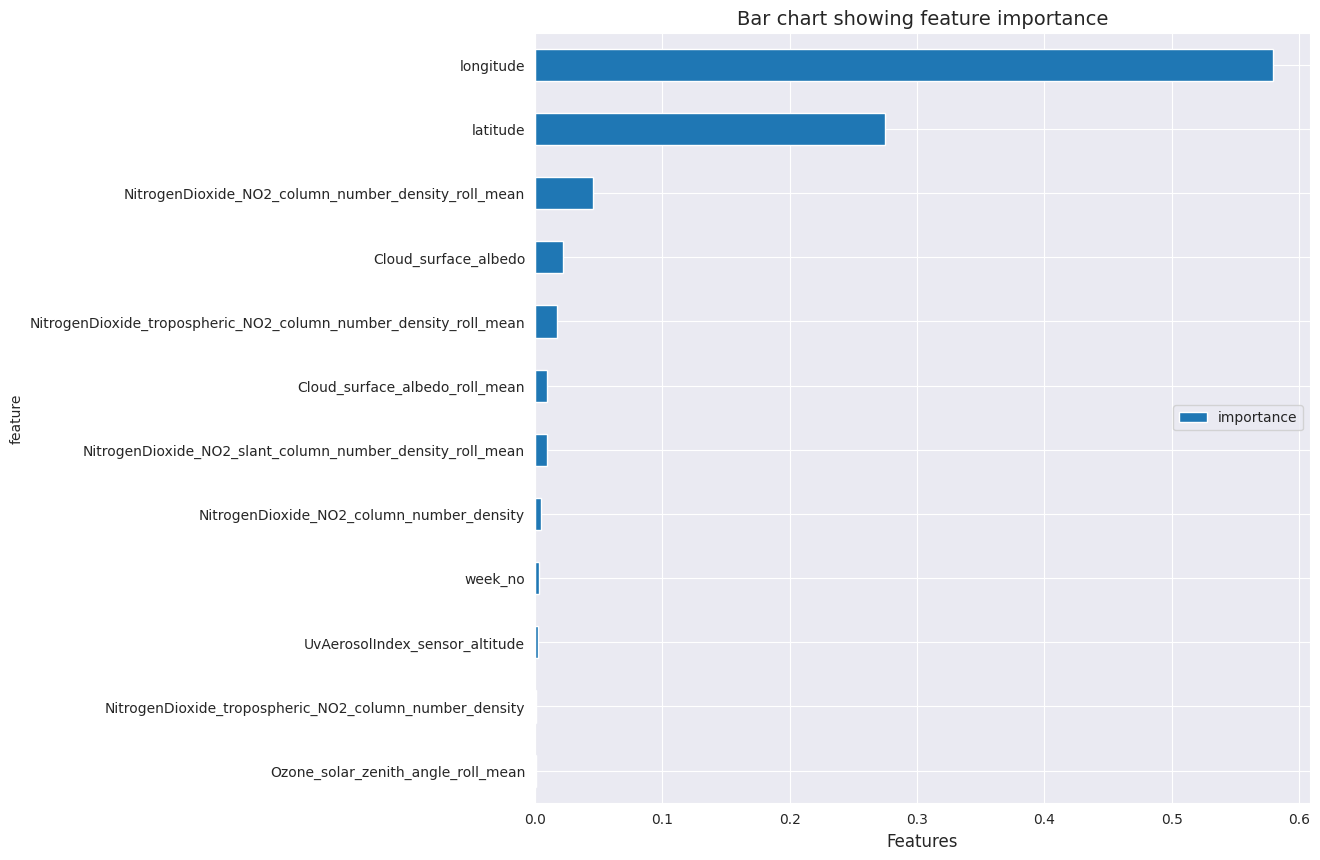

In [ ]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10))
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', fontsize = 14)
plt.xlabel('Features', fontsize = 12)
plt.show()

## 11. b) Boosting models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

# Selecting the independent variables and the target variable
X = train_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location', 'emission'], axis = 1).fillna(0)
y = train_eng.emission

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

## Specifying the boosting model
boost_2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=100, learning_rate=0.001, random_state=1234)
##
## Fitting the bagging model
boost_2.fit(X_train, y_train)
##
## Predicting to the test subset
boost_2.pred = boost_2.predict(X_test)
##
from sklearn import metrics
from sklearn import tree
from sklearn.inspection import permutation_importance
## Estimating the bias, variance and root mean squared error
boost_2_rmse = "{:.4f}".format(np.sqrt(metrics.mean_squared_error(y_test, boost_2.pred)))
boost_2_bias = "{:.4f}".format(np.mean(y_test - boost_2.pred))
boost_2_var  = "{:.4f}".format(np.var(y_test - boost_2.pred))
print(boost_2_rmse, boost_2_bias, boost_2_var)


0.4579 -0.0043 0.2096


In [ ]:
plt.scatter(y_test, boost_2.pred, s=60, edgecolor='black', c='red', label='data, 600 estimators \nlearning rate=0.01')
plt.plot(y_test, y_test, c='blue', label='y=x')
plt.xlim([0, 30])
plt.ylim([0, 30])
plt.xlabel("observed carbon emissions")
plt.ylabel("predicted carbon emissions")
plt.legend()
plt.show()

<a name="Predictions"></a>
## 12. Making predictions of the test set and creating a submission file

In [ ]:
# Make prediction on the test set
# We chose to make predictions on the booster model because of lower RMSE
test_df = test_eng.drop(['ID_LAT_LON_YEAR_WEEK', 'location'], axis = 1).fillna(0)
predictions = boost_2.predict(test_df)

# # Create a submission file
sub_file = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test_eng.ID_LAT_LON_YEAR_WEEK, 'emission': predictions})
sub_file.head()

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-23.53_27.47_2019_1,5.58150
1,ID_-23.53_27.47_2019_2,5.15936
2,ID_-23.53_27.47_2019_3,5.21521
3,ID_-23.53_27.47_2019_4,5.20479
4,ID_-23.53_27.47_2019_5,5.29249


In [ ]:
# Create file
sub_file.to_csv('BaselineSubmission3.csv', index = False) # Download subfile and submit to zindi for scoring